In [61]:
### Hayden Gallo
### Bucci Lab
### gLV dFBA extension such that i can fit co-culture and mono-culture data, using least squares and loss function 
### 10/21/24

import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

import time
import joblib
import multiprocessing
from scipy.stats import truncnorm
import copy
from pathlib import Path
import subprocess

### script for running glv_dfba inference
from helper_functions import *

In [2]:
cerillo_test_data = pd.read_csv('/Users/haydengallo/Documents/Bucci_Lab/cerillo_data/averaged_cerillo.csv', index_col=0)

cerillo_test_data.shape

cerillo_test_data.head()


,Group_together,Time,OD
0,DO/DO,0,0.001683
1,DO/DO,5,0.001717
2,DO/DO,10,0.003267
3,DO/DO,15,0.004917
4,DO/DO,20,0.006667


In [3]:
co_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PCwEB') | (cerillo_test_data['Group_together'] == 'EBwPC')]
co_culture_data = co_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
co_culture_data.head()

Group_together,Time,EBwPC,PCwEB
0,0,0.002300,0.002633
1,5,0.001933,0.002033
2,10,0.003533,0.004433
3,15,0.005367,0.007000
4,20,0.007333,0.009333


In [330]:
EB_mono_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'EB/EB')]
EB_mono_culture_data = EB_mono_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
EB_mono_culture_data['PC'] = 0

EB_mono_culture_data.head()

list_zero = EB_mono_culture_data['PC']

In [332]:
PC_mono_culture_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PC/PC')]
PC_mono_culture_data = PC_mono_culture_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()
PC_mono_culture_data.insert(1, 'EB', list_zero)

PC_mono_culture_data.head()

Group_together,Time,EB,PC/PC
0,0,0,0.002183
1,5,0,0.000917
2,10,0,0.002000
3,15,0,0.003350
4,20,0,0.005033


In [333]:
### Setup parameters for fitting lsq gLV

init_abun_co = [.002, .002]
EB_init_abun_mono = [.002, 0]
PC_init_abun_mono = [0, 0.002]
### so far must manually set initial values of parameters
### also might want to manually specify bounds too, could be something good 

# monoculture growth rate of EB
r_1 = 0.04198
# monoculture growth rate of P. copri
r_2 = .115
# co culture growth rate of EB
gamma_1 = 5
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0
# intraspecies competition of EB
a_1 = -10
# intraspecies competition of P. copri
a_2 = -2.9


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])

total_sim_time = 460
num_t_steps = 460
### first perform original least squares fit of glv

In [334]:
loss = 1e8
loss_tol = 1

# monoculture growth rate of EB
r_1 = 0.04198
# monoculture growth rate of P. copri
r_2 = .115
# co culture growth rate of EB
gamma_1 = 5
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0
# intraspecies competition of EB
a_1 = -10
# intraspecies competition of P. copri
a_2 = -2.9


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])

total_sim_time = 460
num_t_steps = 460
old_cost = 0
cost_diff = 1
count = 0
'''
while (cost_diff > 1e-4):
    count += 1
    print(count)
    if count == 10:
        break


    glv_out, params_co, time, cost_co = ls_glv_fit(init_abun = init_abun_co, params = params_mono, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=co_culture_data)


    glv_out, params_mono, time, cost_mono = ls_glv_fit(init_abun = init_abun_mono, params = params, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=mono_culture_data)

    total_cost = cost_co + cost_mono
    cost_diff = np.abs(total_cost-old_cost)
    old_cost = total_cost
    print(cost_diff)

'''    

    

'\nwhile (cost_diff > 1e-4):\n    count += 1\n    print(count)\n    if count == 10:\n        break\n\n\n    glv_out, params_co, time, cost_co = ls_glv_fit(init_abun = init_abun_co, params = params_mono, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=co_culture_data)\n\n\n    glv_out, params_mono, time, cost_mono = ls_glv_fit(init_abun = init_abun_mono, params = params, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=mono_culture_data)\n\n    total_cost = cost_co + cost_mono\n    cost_diff = np.abs(total_cost-old_cost)\n    old_cost = total_cost\n    print(cost_diff)\n\n'

In [335]:
abun_list = [init_abun_co, EB_init_abun_mono, PC_init_abun_mono]
microbe_data_list = [co_culture_data, EB_mono_culture_data, PC_mono_culture_data]

print(abun_list)
print(microbe_data_list)

[[0.002, 0.002], [0.002, 0], [0, 0.002]]
[Group_together  Time     EBwPC     PCwEB
0                  0  0.002300  0.002633
1                  5  0.001933  0.002033
2                 10  0.003533  0.004433
3                 15  0.005367  0.007000
4                 20  0.007333  0.009333
..               ...       ...       ...
88               440  0.657400  0.432033
89               445  0.672133  0.449533
90               450  0.686133  0.467133
91               455  0.698833  0.485300
92               460  0.711533  0.504033

[93 rows x 3 columns], Group_together  Time     EB/EB  PC
0                  0  0.002517   0
1                  5  0.002000   0
2                 10  0.003483   0
3                 15  0.005233   0
4                 20  0.007117   0
..               ...       ...  ..
88               440  0.280050   0
89               445  0.288367   0
90               450  0.296867   0
91               455  0.305617   0
92               460  0.314900   0

[93 rows x 3 columns]

In [336]:
def ode_model_resid(params, microbe_data, init_abun):
    return (
        microbe_data.iloc[:,1:] - odeint(generalized_gLV, y0 = init_abun, t=microbe_data['Time'], args = (params,))
    ).values.flatten()

def total_loss(params, microbe_data_list, abun_list):
    total_loss_sq = 0
    for i in range(0, len(abun_list)):
        loss = ode_model_resid(params=params, microbe_data=microbe_data_list[i], init_abun=abun_list[i])
        total_loss_sq += np.sum(loss**2)

    return total_loss_sq


In [337]:
total_loss_test = total_loss(params=params, microbe_data_list=microbe_data_list, abun_list=abun_list)
print(total_loss_test)
print(params)


12.577422256782548
[  0.04198   0.115     5.        0.      -10.       -2.9    ]


In [368]:
# monoculture growth rate of EB
r_1 = 0.5
# monoculture growth rate of P. copri
r_2 = .5
# co culture growth rate of EB
gamma_1 = 4
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0.1
# intraspecies competition of EB
a_1 = -7
# intraspecies competition of P. copri
a_2 = -1


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])



bnds = ((0, 10), (0, 10), (0, 10), (-5, 5), (-10, 0), (-10, 0))
results = minimize(total_loss, params, args=(microbe_data_list, abun_list), bounds=bnds, tol = 1e-10)

In [369]:
new_params = results.x
print(new_params)

[ 0.01507112  0.01408723  0.04890572  0.00162419 -0.04596518 -0.02082481]


In [370]:
time = np.arange(0, 460,1)

In [374]:
x_y_co = odeint(generalized_gLV, y0 = init_abun_co, t=time, args = (new_params,))
x_y_EB_mono = odeint(generalized_gLV, y0 = EB_init_abun_mono, t=time, args = (new_params,))
x_y_PC_mono = odeint(generalized_gLV, y0 = PC_init_abun_mono, t=time, args = (new_params,))

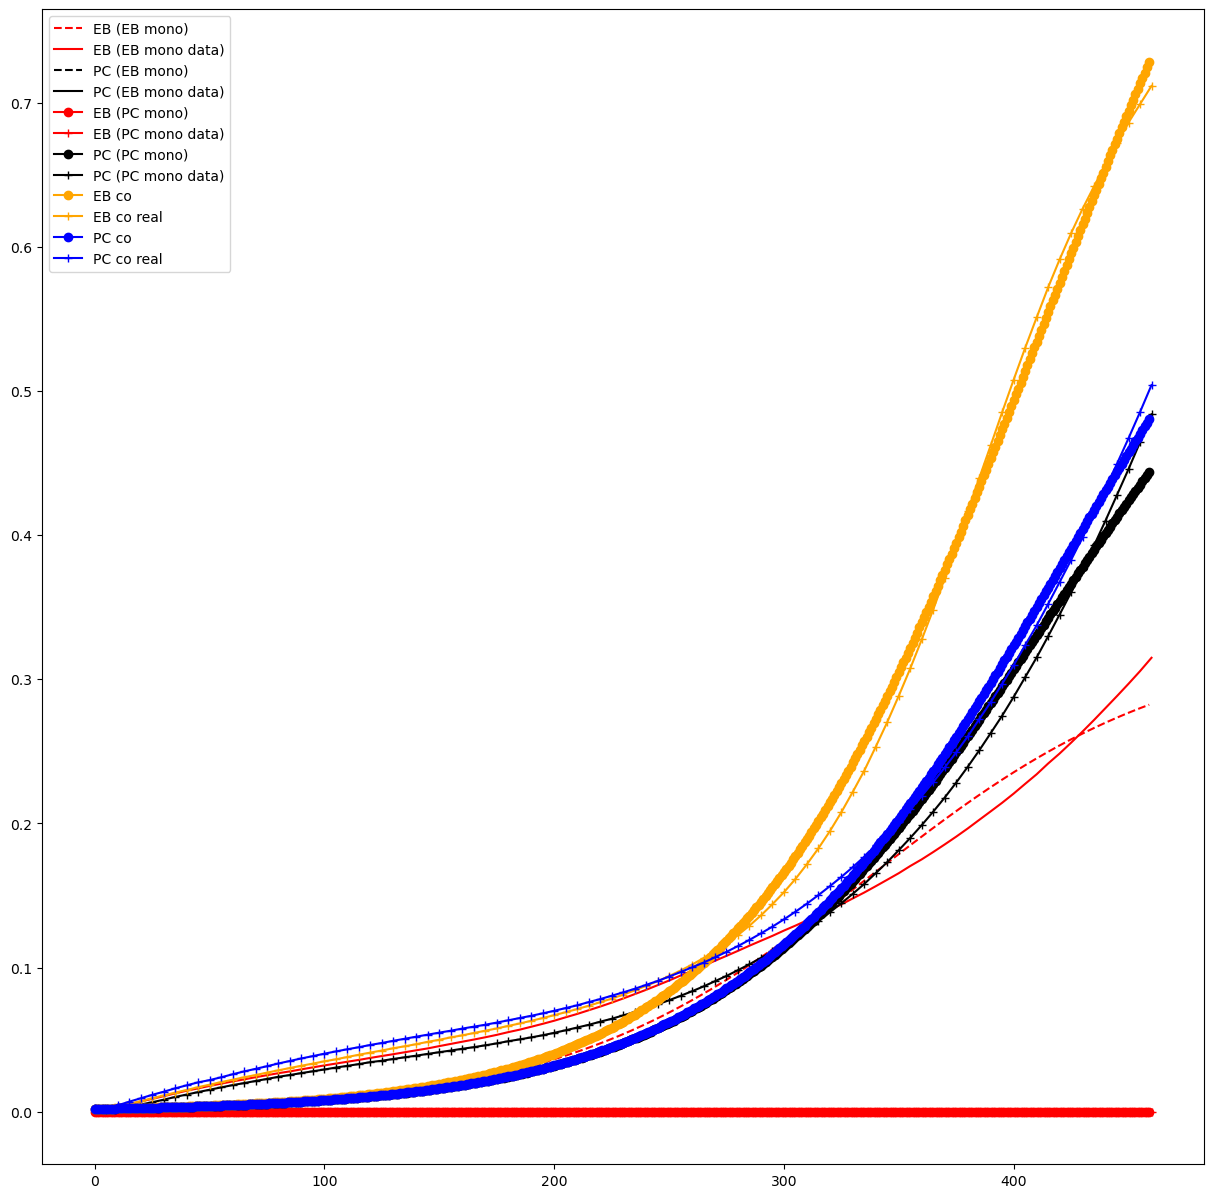

In [392]:
fig, axs = plt.subplots(figsize = (15,15))

plt.plot(time, x_y_EB_mono[:,0], label = 'EB (EB mono)', color = 'red', linestyle ='--')
plt.plot(EB_mono_culture_data['Time'], EB_mono_culture_data['EB/EB'], label = 'EB (EB mono data)', color = 'red')

plt.plot(time, x_y_EB_mono[:,1], label = 'PC (EB mono)', color = 'black', linestyle ='--')
plt.plot(EB_mono_culture_data['Time'], EB_mono_culture_data['PC'], label = 'PC (EB mono data)', color = 'black')

plt.plot(time, x_y_PC_mono[:,0], label = 'EB (PC mono)', color = 'red', marker ='o')
plt.plot(PC_mono_culture_data['Time'], PC_mono_culture_data['EB'], label = 'EB (PC mono data)', color = 'red', marker = '+')

plt.plot(time, x_y_PC_mono[:,1], label = 'PC (PC mono)', color = 'black', marker ='o')
plt.plot(PC_mono_culture_data['Time'], PC_mono_culture_data['PC/PC'], label = 'PC (PC mono data)', color = 'black', marker = '+')

plt.plot(time, x_y_co[:,0], label = 'EB co', color = 'orange', marker = 'o')
plt.plot(co_culture_data['Time'], co_culture_data['EBwPC'], label = 'EB co real', color = 'orange', marker = '+')

plt.plot(time, x_y_co[:,1], label = 'PC co', color = 'blue', marker = 'o')
plt.plot(co_culture_data['Time'], co_culture_data['PCwEB'], label = 'PC co real', color = 'blue', marker = '+')

#plt.plot(mono_culture_data['Time'], mono_culture_data['EB/EB'], label = 'EB mono real', color = 'red')

plt.legend()
plt.show()


In [390]:
new_params

array([ 0.01507112,  0.01408723,  0.04890572,  0.00162419, -0.04596518,
       -0.02082481])

In [476]:
@as_op(itypes=[pt.dvector, pt.dvector, pt.dmatrix], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(params_ls, init_abun, microbe_data):

    time_values = microbe_data[:,0]
    #print(time_values)

    return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))

def bayesian_glv_setup(params_init, microbe_data_list, abun_list):

    #params = results.x  # least squares solution used to inform the priors
    with pm.Model() as model:
        # Priors
        r_1 = pm.TruncatedNormal("r_1", mu=params_init[0], sigma=0.1, lower=0, initval=params_init[0])
        r_2 = pm.TruncatedNormal("r_2", mu=params_init[1], sigma=0.01, lower=0, initval=params_init[1])
        ### Should I make gamma normally distributed? or at least gamma_2 for PC due to 
        gamma_1 = pm.TruncatedNormal("gamma_1", mu=params_init[2], sigma=0.1, lower=0, initval=params_init[2])
        gamma_2 = pm.TruncatedNormal("gamma_2", mu=params_init[3], sigma=0.01, lower=0, initval=params_init[3])
        a_1 = pm.TruncatedNormal("a_1", mu=params_init[4], sigma=1, upper=0, initval=params_init[4])
        a_2 = pm.TruncatedNormal("a_2", mu=params_init[5], sigma=1, upper=0, initval=params_init[5])

        #for i in range(0, len(microbe_data_list)):
        #    # Likelihood for each dataset, with a unique sigma per dataset
        #    sigma = pm.HalfNormal(f"sigma_{i}", 10)

        # Loop over each dataset
        for i, microbe_data in enumerate(microbe_data_list):
            # ODE solution for each dataset
            ode_solution = pytensor_forward_model_matrix(
                pm.math.stack([r_1, r_2, gamma_1, gamma_2, a_1, a_2]), pm.math.stack(abun_list[i]), pt.as_tensor(microbe_data.values)
            )
            sigma = pm.HalfNormal(f"sigma_{i}", 10)

            pm.Normal(f"Y_obs_{i}", mu=ode_solution, sigma=sigma, observed=microbe_data.iloc[:,1:].values)

        return model




def bayesian_glv_run(model, num_samples, chains):
    # Variable list to give to the sample step parameter
    vars_list = list(model.values_to_rvs.keys())[:7]+[list(model.values_to_rvs.keys())[8]]+[list(model.values_to_rvs.keys())[10]]

    sampler = "DEMetropolisZ"
    tune = draws = num_samples
    with model:
        trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=chains, cores = 10)
    trace = trace_DEMZ
    #az.summary(trace)

    return trace

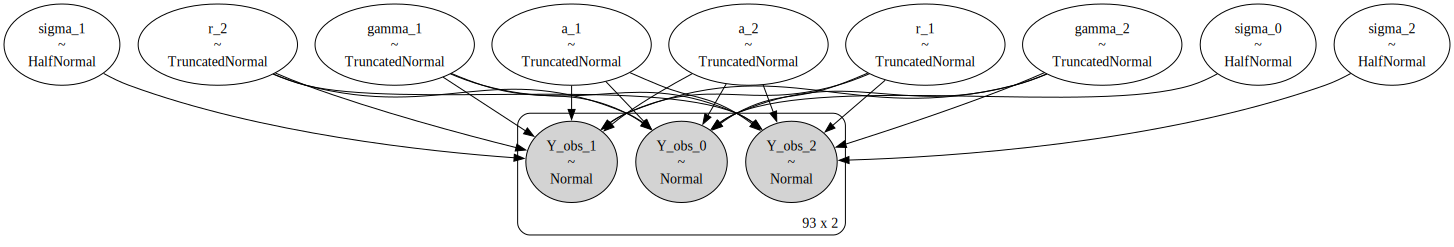

In [477]:
model = bayesian_glv_setup(params_init=new_params, microbe_data_list=microbe_data_list, abun_list=abun_list)
(pm.model_to_graphviz(model=model))

In [480]:
trace = bayesian_glv_run(model=model, num_samples=100000, chains =10)

Multiprocess sampling (10 chains in 10 jobs)
DEMetropolisZ: [r_1, r_2, gamma_1, gamma_2, a_1, a_2, sigma_0, sigma_1, sigma_2]


Output()

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3700483455312D+03   r2 =  0.2826736460671D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3700483455312D+03   r2 =  0.2826736460671D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3700483455312D+03   r2 =  0.2826736460671D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3700483455312D+03   r2 =  0.2826736460671D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3650605193432D+03   r2 =  0.2791396709280D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3650605193432D+03   r2 =  0.2791396709280D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3650605193432D+03   r2 =  0.2791396709280D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3650605193432D+03   r2 =  0.2791396709280D-13
 lsoda--  warning..internal t (=r1) 

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3500895763582D+03   r2 =  0.2384703865498D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3500895763582D+03   r2 =  0.2384703865498D-13


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2851743294718D+03   r2 =  0.2813644157279D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2851743294718D+03   r2 =  0.2813644157279D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2851743294718D+03   r2 =  0.2813644157279D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2851743294718D+03   r2 =  0.2813644157279D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2822247859304D+03   r2 =  0.2707994159855D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2822247859304D+03   r2 =  0.2707994159855D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2822247859304D+03   r2 =  0.2707994159855D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2822247859304D+03   r2 =  0.2707994159855D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1800289042504D+03   r2 =  0.1391272908620D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1800289042504D+03   r2 =  0.1391272908620D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1800289042504D+03   r2 =  0.1391272908620D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1800289042504D+03   r2 =  0.1391272908620D-13
 lsoda--  warning..internal t (=r1) 

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3957190253746D+03   r2 =  0.2803946890671D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3957190253746D+03   r2 =  0.2803946890671D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3957190253746D+03   r2 =  0.2321619206582D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3957190253746D+03   r2 =  0.2321619206582D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3513887408775D+03   r2 =  0.2602784866498D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3513887408775D+03   r2 =  0.2602784866498D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3513887408775D+03   r2 =  0.2155060552835D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3513887408775D+03   r2 =  0.2155060552835D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2403974404273D+03   r2 =  0.1343503747016D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2403974404273D+03   r2 =  0.1343503747016D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2403974404273D+03   r2 =  0.1343503747016D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2403974404273D+03   r2 =  0.1343503747016D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353682738849D+03   r2 =  0.1224827684881D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353682738849D+03   r2 =  0.1224827684881D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353682738849D+03   r2 =  0.1224827684881D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353682738849D+03   r2 =  0.1224827684881D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400498968805D+03   r2 =  0.1331127954339D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400498968805D+03   r2 =  0.1331127954339D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400498968805D+03   r2 =  0.1331127954339D-13


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3100858415194D+03   r2 =  0.2785740043873D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3100858415194D+03   r2 =  0.2785740043873D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3100858415194D+03   r2 =  0.2785740043873D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3100858415194D+03   r2 =  0.2785740043873D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2952009198736D+03   r2 =  0.2479731807526D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2952009198736D+03   r2 =  0.2479731807526D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2952009198736D+03   r2 =  0.2479731807526D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2952009198736D+03   r2 =  0.2479731807526D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2720918864569D+03   r2 =  0.2764404435508D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2720918864569D+03   r2 =  0.2764404435508D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2720918864569D+03   r2 =  0.2288878742015D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2720918864569D+03   r2 =  0.2288878742015D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3200144224494D+03   r2 =  0.2740315196782D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3200144224494D+03   r2 =  0.2740315196782D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3200144224494D+03   r2 =  0.2740315196782D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3200144224494D+03   r2 =  0.2740315196782D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1505360734737D+03   r2 =  0.1360329623293D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1505360734737D+03   r2 =  0.1360329623293D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1505360734737D+03   r2 =  0.1126329243800D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1505360734737D+03   r2 =  0.1126329243800D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000172648630D+02   r2 =  0.3289279622610D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000172648630D+02   r2 =  0.3289279622610D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000172648630D+02   r2 =  0.3289279622610D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000172648630D+02   r2 =  0.3289279622610D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4400324609735D+03   r2 =  0.2723341345735D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4400324609735D+03   r2 =  0.2723341345735D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4400324609735D+03   r2 =  0.2723341345735D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4400324609735D+03   r2 =  0.2723341345735D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7569959187526D+02   r2 =  0.6962240384653D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7569959187526D+02   r2 =  0.6962240384653D-14


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000285907221D+02   r2 =  0.3552306538142D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000285907221D+02   r2 =  0.3552306538142D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000285907221D+02   r2 =  0.3552306538142D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000285907221D+02   r2 =  0.3552306538142D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150763016829D+03   r2 =  0.2402582768942D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150763016829D+03   r2 =  0.2402582768942D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150763016829D+03   r2 =  0.2402582768942D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150763016829D+03   r2 =  0.2402582768942D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8001810354181D+02   r2 =  0.6290430946679D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8001810354181D+02   r2 =  0.6290430946679D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8001810354181D+02   r2 =  0.6290430946679D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8001810354181D+02   r2 =  0.6290430946679D-14
 lsoda--  warning..internal t (=r1) 

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_30056/3217802594.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=time_values, args=(params_ls,))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7000234852537D+02   r2 =  0.6614535022988D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7000234852537D+02   r2 =  0.6614535022988D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7000234852537D+02   r2 =  0.6614535022988D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7000234852537D+02   r2 =  0.6614535022988D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8639254037769D+02   r2 =  0.6456248428533D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8639254037769D+02   r2 =  0.6456248428533D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8639254037769D+02   r2 =  0.6456248428533D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8639254037769D+02   r2 =  0.5371117240637D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150685692136D+03   r2 =  0.2762825766255D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150685692136D+03   r2 =  0.2762825766255D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150685692136D+03   r2 =  0.2762825766255D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4150685692136D+03   r2 =  0.2762825766255D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5500617185325D+02   r2 =  0.2987565214415D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5500617185325D+02   r2 =  0.2987565214415D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5500617185325D+02   r2 =  0.2987565214415D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5500617185325D+02   r2 =  0.2987565214415D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8002354176216D+02   r2 =  0.6173258510238D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8002354176216D+02   r2 =  0.6173258510238D-14


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001793258142D+02   r2 =  0.6865121754640D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001793258142D+02   r2 =  0.6865121754640D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001793258142D+02   r2 =  0.6865121754640D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001793258142D+02   r2 =  0.6865121754640D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1850505155744D+03   r2 =  0.1379739893710D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1850505155744D+03   r2 =  0.1379739893710D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1850505155744D+03   r2 =  0.1379739893710D-13


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5001084723374D+02   r2 =  0.3534022583461D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5001084723374D+02   r2 =  0.3534022583461D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5001084723374D+02   r2 =  0.3534022583461D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5001084723374D+02   r2 =  0.3534022583461D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7500179822366D+02   r2 =  0.6499297627390D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7500179822366D+02   r2 =  0.6499297627390D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7500179822366D+02   r2 =  0.6499297627390D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7500179822366D+02   r2 =  0.6499297627390D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000574388014D+02   r2 =  0.3541438625337D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000574388014D+02   r2 =  0.3541438625337D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000574388014D+02   r2 =  0.3541438625337D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000574388014D+02   r2 =  0.3541438625337D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001998062831D+02   r2 =  0.6713209270815D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001998062831D+02   r2 =  0.6713209270815D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001998062831D+02   r2 =  0.6713209270815D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001998062831D+02   r2 =  0.6713209270815D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7015623854489D+02   r2 =  0.7040326157646D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7015623854489D+02   r2 =  0.7040326157646D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7015623854489D+02   r2 =  0.5829267480514D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7015623854489D+02   r2 =  0.5829267480514D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2600475595105D+03   r2 =  0.2506065092366D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2600475595105D+03   r2 =  0.2506065092366D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2600475595105D+03   r2 =  0.2506065092366D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2600475595105D+03   r2 =  0.2506065092366D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4350343393731D+03   r2 =  0.2566088416716D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4350343393731D+03   r2 =  0.2566088416716D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4350343393731D+03   r2 =  0.2566088416716D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4350343393731D+03   r2 =  0.2566088416716D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7502178493010D+02   r2 =  0.5844122601925D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7502178493010D+02   r2 =  0.5844122601925D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7502178493010D+02   r2 =  0.5844122601925D-14


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4400915473442D+03   r2 =  0.2326180826918D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4400915473442D+03   r2 =  0.2326180826918D-13


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4200053556595D+03   r2 =  0.2706995394931D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4200053556595D+03   r2 =  0.2706995394931D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4200053556595D+03   r2 =  0.2706995394931D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4200053556595D+03   r2 =  0.2706995394931D-13
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6500026651412D+02   r2 =  0.6921015989934D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6500026651412D+02   r2 =  0.6921015989934D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6500026651412D+02   r2 =  0.6921015989934D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6500026651412D+02   r2 =  0.6921015989934D-14
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1153356213271D+03   r2 =  0.6235922573037D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1153356213271D+03   r2 =  0.6235922573037D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1153356213271D+03   r2 =  0.6235922573037D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1153356213271D+03   r2 =  0.6235922573037D-14
 lsoda--  warning..internal t (=r1) 

Sampling 10 chains for 100_000 tune and 100_000 draw iterations (1_000_000 + 1_000_000 draws total) took 508 seconds.


In [481]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_1,-0.048,0.001,-0.051,-0.045,0.0,0.0,19205.0,21184.0,1.0
a_2,-0.019,0.001,-0.021,-0.018,0.0,0.0,12399.0,9688.0,1.0
gamma_1,0.051,0.002,0.048,0.055,0.0,0.0,21899.0,12138.0,1.0
gamma_2,0.002,0.000,0.001,0.002,0.0,0.0,19897.0,9605.0,1.0
r_1,0.015,0.000,0.015,0.015,0.0,0.0,23136.0,23376.0,1.0
r_2,0.014,0.000,0.014,0.014,0.0,0.0,13332.0,9775.0,1.0
sigma_0,0.023,0.001,0.021,0.025,0.0,0.0,25479.0,39176.0,1.0
sigma_1,0.013,0.001,0.012,0.015,0.0,0.0,21095.0,20080.0,1.0
sigma_2,0.012,0.001,0.011,0.013,0.0,0.0,22345.0,26802.0,1.0
